In [23]:
import numpy as np
import pandas as pd
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Intro/Data Exploration

Black-scholes and other updated variations of the original theorem used for option pricing largely operate under the assumption of lognormal returns. This is one of the shortfalls of Black-Scholes for option pricing, as stock returns demonstratably poorly fit a lognormal distribution. The most obvious difference is that real return distributions tend to exhibit much fatter tails. For the sake of this analysis, the return distribution of various ETFs (data tends to have less complications with survival bias, etc.) will be explored vs the lognormal assumption. Other probability distribution approximation methods will be comparatively evaluated.

In [24]:
#Daily adjusted price data pulled using yahoo finance API and prepped elsewhere
df= pd.read_pickle('df.pickle')
df['DATE']= pd.to_datetime(df['DATE'])
#Will focus on prominent ETF Symbols for sake of avoding additional abnormalities
etf_sym= ['SPY', 'IVV', 'VTI', 'QQQ', 'AGG', 'VTV', 'VUG', 'IWM', 'IJR', 'IWF', 'IJH', 'IWD',
    'VO', 'LQD', 'VB', 'VGT', 'XLK', 'XLF', 'ITOT', 'VNQ']
df_etf= df[['DATE']+ etf_sym]
#Convert to daily returns
df_etf[etf_sym]/= df_etf[etf_sym].shift()
#Filter for time where all symbol return present
df_etf= df_etf[df_etf.isna().sum(axis=1)==0].reset_index(drop=True)
#Get various moving window drift/vol
for window in [10, 50, 250]:
    for sym in etf_sym:
        #Need to also shift for sake of not cheating on including current return
        df_etf[f'{sym}_drift_{window}']= df_etf[sym].rolling(window).mean().shift()
        df_etf[f'{sym}_vol_{window}']= df_etf[sym].rolling(window).std().shift()
#Create converted etf df for compatibility with algorithms
trans_etf= pd.concat([df_etf[['DATE']+[c for c in df_etf.columns if sym in c]].rename(columns=
    {c:c.replace(sym, "ret") for c in df_etf.columns if sym in c}).assign(sym=sym) for sym in etf_sym], 
    ignore_index=True)
trans_etf= trans_etf.dropna().reset_index(drop=True)
#Define train/test masks
cutoff= '2020-03-01'
trn= trans_etf['DATE']< cutoff
tst= trans_etf['DATE']>= cutoff
#Define relevant cols
xcols= ['ret_vol_10', 'ret_vol_50', 'ret_vol_250']
ycol= 'ret'
trans_etf

,DATE,ret,ret_drift_10,ret_vol_10,ret_drift_50,ret_vol_50,ret_drift_250,ret_vol_250,sym
0,2005-09-27,0.999753,0.998186,0.005231,0.999895,0.005730,1.000434,0.006440,SPY
1,2005-09-28,1.000987,0.998716,0.005076,0.999970,0.005703,1.000436,0.006439,SPY
2,2005-09-29,1.008137,0.999179,0.005049,0.999880,0.005649,1.000372,0.006354,SPY
3,2005-09-30,1.003098,1.000041,0.005794,0.999974,0.005748,1.000398,0.006372,SPY
4,2005-10-03,0.996424,0.999640,0.005373,1.000153,0.005703,1.000409,0.006375,SPY
...,...,...,...,...,...,...,...,...,...
78015,2021-03-22,1.007073,1.004152,0.010483,1.001913,0.009590,1.002174,0.019264,VNQ
78016,2021-03-23,0.998573,1.003996,0.010420,1.002093,0.009601,1.001843,0.018443,VNQ
78017,2021-03-24,0.994396,1.003191,0.010505,1.001870,0.009549,1.001622,0.018146,VNQ
78018,2021-03-25,1.010182,1.001633,0.010542,1.002023,0.009362,1.001317,0.017616,VNQ


This visualization provides a broad view of the ETFs that will be included in analysis

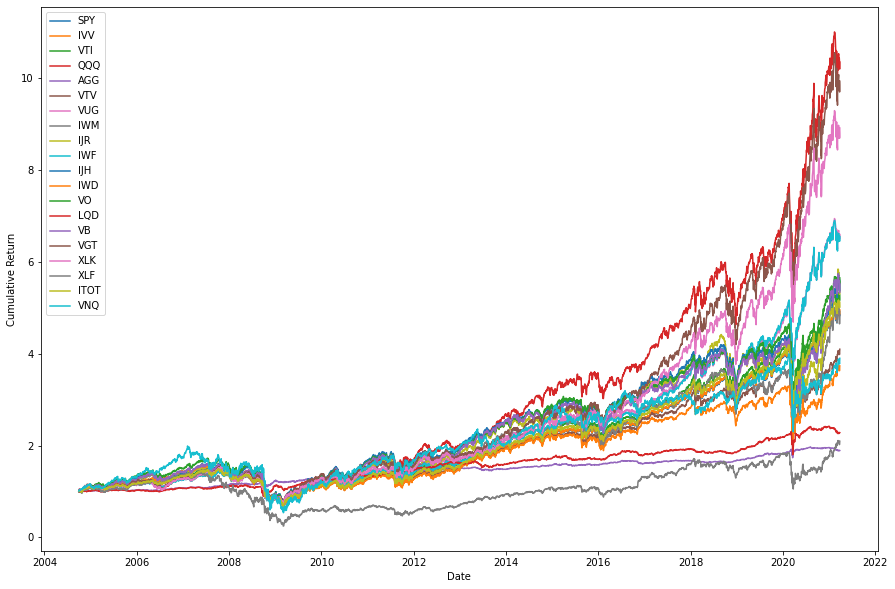

In [25]:
#Explore ETF comparative cumulative return for insight on data
plt.figure(figsize=(15,10))
[plt.plot(df_etf['DATE'], df_etf[sym].cumprod(), label=sym) for sym in etf_sym]
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

These graphs demonstrate that the distribution of retun with higher historic volatility are expected 
to continue to have a more volatile return distribution

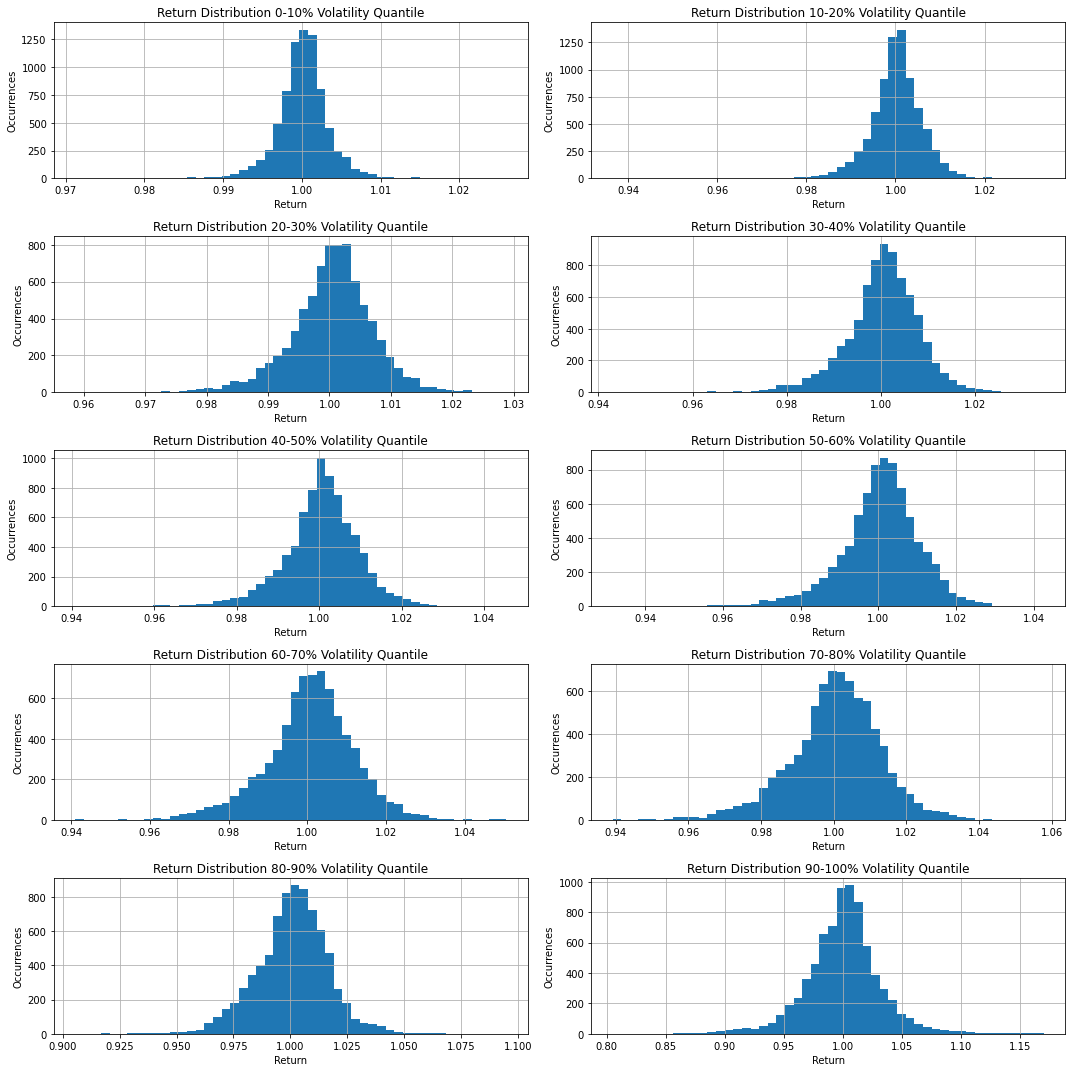

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(15,15))
for quant in range(10):
    plt_ax= ax[int(quant/2), quant%2]
    lo= trans_etf['ret_vol_10']>=trans_etf['ret_vol_10'].quantile(quant/10)
    hi= trans_etf['ret_vol_10']<=trans_etf['ret_vol_10'].quantile((quant+1)/10)
    trans_etf[lo*hi]['ret'].hist(bins=50, ax=plt_ax)
    plt_ax.set_xlabel('Return')
    plt_ax.set_ylabel('Occurrences')
    plt_ax.set_title(f'Return Distribution {quant*10}-{(quant+1)*10}% Volatility Quantile')
plt.tight_layout()
plt.show()

# SPY Observed Return Distribution

To get into specific examples, the plot below shows the return distribution for the SPY ETF over the covered timeframe

Text(0.5, 1.0, 'Actual Return Distribution Histogram')

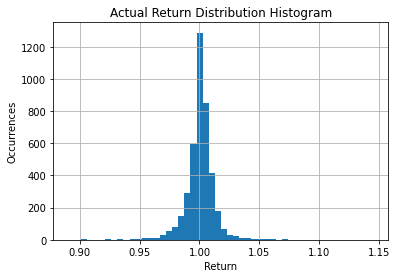

In [28]:
df_etf['SPY'].hist(bins=50)
plt.xlabel('Return')
plt.ylabel('Occurrences')
plt.title('Actual Return Distribution Histogram')

# Simulated SPY Distribution Using Black-Scholes Lognormal Assumption

Below shows how this return distribution would be approximated by the lognormal assumption (in-sample). Notice it looks completely different from the actual SPY distribution, most notably in the tails. This result lines up with what has often been reported in research.

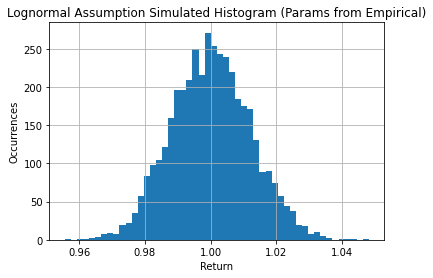

In [29]:
np.random.seed(0)
logn_sim= np.random.lognormal(df_etf['SPY'].mean()-1, df_etf['SPY'].std(), len(df_etf['SPY']))
pd.Series(logn_sim).hist(bins=50)
plt.xlabel('Return')
plt.ylabel('Occurrences')
plt.title('Lognormal Assumption Simulated Histogram (Params from Empirical)')
plt.show()

# Proposed Alternative PDF Approximation Methodologies

# Particle Filter

One popular methodology that could potentially fit the needs of this problem is the particle filter. The particle filter can be used to approximate a probability distrbiution by sampling potential result particles weighted by their importance score. This importance score is flexible for user discretion given problem domain. In this situation the particles can be historical observations, and the importance scores can scale to iverse distance/similarity between current state and historical observations. For comparison, this methodology is similar to KNN but is stochasitc rather than deterministic (due to importance sampling) and is focused on approximating a distribution rather than a point prediction. Also note that converting this filter distribution to a usable PDF form is a little murky seeing that the particles are point masses, so the methodology used here bins based on standard deviation derived cutoffs. Below cell has the implementation of this methodology.

In [30]:
class particle_filter(object):
    def __init__(self, particles, seed=0):
        #Define particle count for each prediction and random seed
        self.particles= particles
        self.seed= seed
        np.random.seed(seed)
    
    def scaler_fit(self, x):
        #Define scale to be reused
        self.mn, self.std= x.mean(axis=0), x.std(axis=0)
        
    def scaler_trans(self, x):
        #Normalize
        return (x- self.mn)/self.std
    
    def dist(self, x1, x2):
        #Calculate distance
        x1a, x2a= np.array(x1), np.array(x2)
        return ((x1a.reshape(x1a.shape[0], 1, x1a.shape[1])-x2a)**2).sum(axis=2)**.5
    
    def wt_samp(self, imp, burn_tune=2):
        #slightly modified resample wheel alg from AI4R
        w= list(imp/imp.sum())
        N = burn_tune*self.particles
        new_particles = []
        index = int(np.random.random() * N)
        beta = 0.0
        mw = max(w)
        for u in np.random.uniform(0, 1, N):
            beta += u * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % N
            new_particles.append(index)
        return new_particles[N- self.particles:]
    
    def fit(self, x, y):
        #Fit particle filter and store particles from training data
        self.scaler_fit(x)
        self.pop_x= self.scaler_trans(x)
        self.pop_y= np.array(y)
    
    def pred(self, x, tune=1):
        #Predict dependent variable distribution for each observation
        return np.array([self.pop_y[self.wt_samp(1/d**tune)] for d in self.dist(self.scaler_trans(x), self.pop_x)])
           
    def pdf(self, x, y, tune=1):
        pred= self.pred(x, tune).flatten()
        z_abs= abs(pred- pred.mean())/pred.std()
        #Define percentage within each sd bin for pdf
        sdq= np.array(8*[2]).cumprod()/16
        qbins= np.array([(z_abs<sd).mean() for sd in sdq])
        qbins[1:]-= qbins[:-1]
        qbins/= (sdq*pred.std())
        qbins[0]/= 2
        #Define pdf dictionary that will convert input to pdf value
        pdf_map= dict(zip(sdq, qbins))
        #Bin each observation and return pdf value
        return np.vectorize(lambda x: pdf_map[min(sdq[sdq > x])])(abs(y- pred.mean())/pred.std())  
    
    def likelihood(self, x, y, tune=1):
        #Return likelihood of series of observations
        return self.pdf(x, y, tune).prod()

Here is an example for what the particle filter distribution can look like applied to SPY

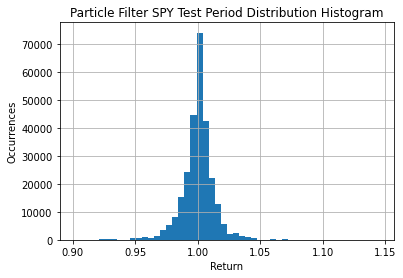

In [31]:
filt= particle_filter(1000)
filt.fit(trans_etf[trn][xcols], trans_etf[trn][ycol])
pd.Series(filt.pred(trans_etf[tst & (trans_etf['sym']=='SPY')][xcols]).flatten()).hist(bins=50)
plt.xlabel('Return')
plt.ylabel('Occurrences')
plt.title('Particle Filter SPY Test Period Distribution Histogram')
plt.show()

For performance comparison, likelihood over each month in the out-of-sample period for SPY is compared using the traditional lognormal approximation (with 50 day rolling vol) and the particle filter methodology. Performance appears relatively even using this metric as comparison.

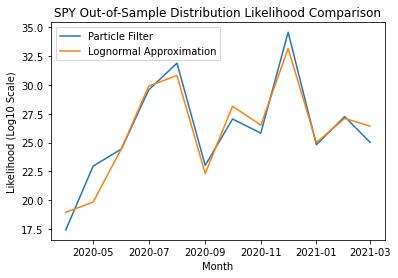

In [32]:
filt= particle_filter(1000)
filt.fit(trans_etf[trn][xcols], trans_etf[trn][ycol])
metrics= {'dts': [], 'pfilt': [], 'lognorm': []} 
df['DATE'].dt.to_period('M')
for month in trans_etf[tst]['DATE'].dt.to_period('M').unique()[1:]:
    tmp_tst= trans_etf[(trans_etf['DATE'].dt.to_period('M')==month) & (trans_etf['sym']=='SPY')]
    metrics['dts'].append(month.to_timestamp())
    metrics['pfilt'].append(np.log10(filt.likelihood(tmp_tst[xcols], tmp_tst[ycol])))
    metrics['lognorm'].append(np.log10(np.prod([lognorm.pdf(ro[ycol], ro['ret_vol_50']) 
        for i, ro in tmp_tst.iterrows()])))

#Plotting
plt.plot(metrics['dts'], metrics['pfilt'], label='Particle Filter')
plt.plot(metrics['dts'], metrics['lognorm'], label='Lognormal Approximation')
plt.xlabel('Month')
plt.ylabel('Likelihood (Log10 Scale)')
plt.title('SPY Out-of-Sample Distribution Likelihood Comparison')
plt.legend()
plt.show()

# Conclusion/Future Exploration

When developing the particle filter methodolgy for this purpose, there were a fair amount of assumptions made to get it in a usable state, such as how to define the importance weight function. More instensive exploration into what variables could well represent distribution similarity, how greedy the importance weigthing should be, and how the PDF is approximated from particles are some areas that could improve particle filter performance. There are also many other approaches that could be used besides the particle filter for PDF approximation, such as a piecewise binary classification model that calculates probability above/below different return markers or other distribution approximation methods I'm unaware of. Using the lognormal assumption has some benefits related to simplicty of equation handling but some clear shortfalls in accuracy.